<a href="https://colab.research.google.com/github/nit29sin/Pneumonia-Detection/blob/main/Pneumonia_Detection_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Libraries
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import glob
from sklearn.model_selection import train_test_split
import os

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 16

In [ ]:
filenames = glob.glob(str('/content/drive/MyDrive/chest_xray5/train/*/*'))
filenames.extend(glob.glob (str('/content/drive/MyDrive/chest_xray5/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1057
Pneumonia images count in training set: 3128


In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/content/drive/MyDrive/chest_xray5/train/PNEUMONIA/person871_virus_1517.jpeg'
b'/content/drive/MyDrive/chest_xray5/train/PNEUMONIA/person30_bacteria_149.jpeg'
b'/content/drive/MyDrive/chest_xray5/train/PNEUMONIA/person688_virus_1282.jpeg'
b'/content/drive/MyDrive/chest_xray5/train/PNEUMONIA/person1455_bacteria_3784.jpeg'
b'/content/drive/MyDrive/chest_xray5/train/PNEUMONIA/person811_virus_1447.jpeg'


2022-04-22 15:09:36.239368: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-22 15:09:36.355012: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [ ]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in glob.glob(str("/content/drive/MyDrive/chest_xray/train/*"))])

CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [ ]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [ ]:
test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/chest_xray5/test',
                                                  target_size = (180,180),
                                                  batch_size = 16,
                                                  class_mode = 'binary'
                                                  )

Found 624 images belonging to 2 classes.


In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
model = build_model()
model.summary()
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
    
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=5,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

In [ ]:
model.save("/content/drive/MyDrive/chest_xray/models/modele5.h5")

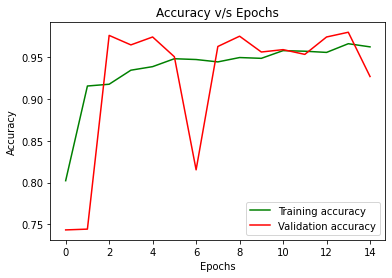

In [ ]:
accuracy_train = history.history['accuracy']
accuracy_val=  history.history['val_accuracy']
plt.plot( accuracy_train, 'g', label='Training accuracy')
plt.plot( accuracy_val, 'r', label='Validation accuracy')
plt.title('Accuracy v/s Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

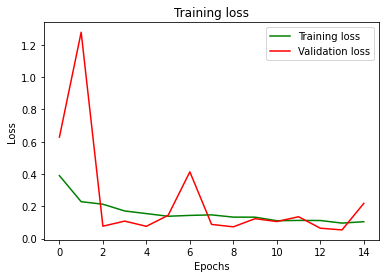

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot( loss_train, 'g', label = 'Training loss' )
plt.plot( loss_val, 'r', label = 'Validation loss' )
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

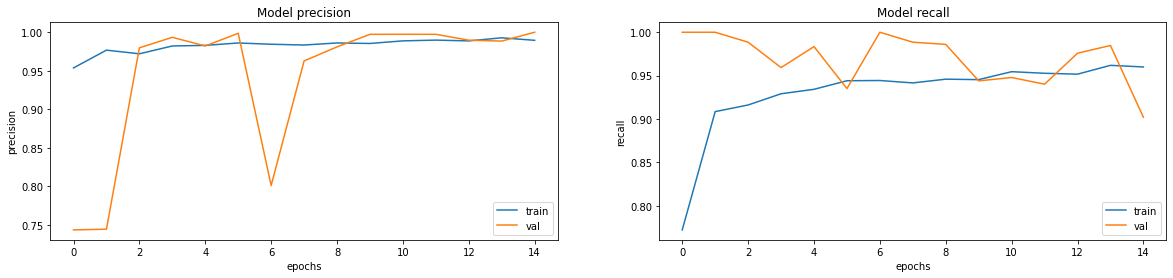

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax = ax.ravel()

for i, m in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[m])
    ax[i].plot(history.history['val_' + m])
    ax[i].set_title('Model {}'.format(m))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(m)
    ax[i].legend(['train', 'val'])

In [ ]:
import tensorflow as tf
model2 = keras.models.load_model('/content/drive/MyDrive/chest_xray/test/model3.h5')

In [ ]:
model2.evaluate(test_dataset)

In [ ]:
model2.predict(test_dataset)

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
img = image.load_img('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_478.jpeg',target_size=(180,180))
#x = image.img_to_array(img)
x = img_to_array(img)
x  = np.expand_dims(x, axis=0)
#images = np.vstack([x])
classes = model2.predict(x)
print(classes[0])
if classes[0] < 0.5:
  print("Normal")
else:
  print("Pneumonia")

[1.]
Pneumonia


In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import cv2
image1 = image.load_img('/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0009-0001.jpeg',target_size=(180,180))
image1  = np.asarray(image1)
img = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img_reshape = img[np.newaxis,...]
#images = np.vstack([x])
classes = model2.predict(img_reshape)
print(classes[0])
if classes[0] < 0.5:
  print("Normal")
else:
  print("Pneumonia")

[0.]
Normal


In [ ]:
!pip install streamlit

In [ ]:
!pip install -q streamlit

In [ ]:
!pip install -U Pillow

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, load_img
import PIL
from PIL import Image, ImageOps
import os
import cv2
st.header ("Image Classifier")

def load_model():
  model=tf.keras.models.load_model('/content/drive/MyDrive/chest_xray/test/model3.h5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()  

file = st.file_uploader("Choose the file", type = ['jpg', 'jpeg', 'png'])
st.set_option('deprecation.showfileUploaderEncoding', False)

def import_and_predict(image_data, model):
  size = (180,180)
  image1 = ImageOps.fit(image_data, size, Image.ANTIALIAS)
  image1  = np.asarray(image1)
  #image1 = np.vstack([image1])
  img = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  img_reshape = img[np.newaxis,...]
  classes = model.predict(img_reshape)
  return classes

if file is None:
    st.text("Please upload an image file")
else:
    image1 = Image.open(file)
    st.image(image1, use_column_width=True)
    classes = import_and_predict(image1, model)
    st.write(classes)
    if classes[0] < 0.5:
      st.write("Normal")
    else:
      st.write("Pneumonia")

Overwriting app.py


In [ ]:
!pip install pyngrok

     |████████████████████████████████| 745 kB 3.5 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=4382298de219cab64d678c2994c1954c2b0f8ac75be3c124f0f8bead1c0d401c
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [ ]:
!ngrok authtoken 1rjgsHVSomsVLiXWDpZvFr3VR48_HU5YCz52mUUnG95XQsmv

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2022-04-29 05:24:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  6.58MB/s    in 2.0s    

2022-04-29 05:24:41 (6.58 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]



In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: ngrok                   


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://3650-35-194-254-240.ngrok.io


In [ ]:
!streamlit run /content/app.py

2022-04-29 05:54:10.716 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.194.254.240:8501

2022-04-29 05:54:37.591256: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/content/app.py:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image1 = ImageOps.fit(image_data, size, Image.ANTIALIAS)
